In [381]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [382]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [383]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

df = get_data()

In [384]:

# subset of the data
df1 = df[[
        # 'gdp_total',
        # 'imports_goods_services',
        # 'household_cons',
        # 'gov_consumption', 
        # 'investments', 
        # 'gpd_invest_business_households',
        # 'gov_invest', 
        # 'change_supply', 
        # 'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

In [385]:

#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

### Save transformations of GDP

In [386]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))


GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()
GDP_TRANSFORMATIONS.index = pd.DatetimeIndex(GDP_TRANSFORMATIONS.index)

In [387]:
df1

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40327.000000,38359.000000,NaN,468248.7,336966.8,NaN,158215.5,58374.6
1995-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41137.000000,46028.000000,NaN,473342.0,339719.0,NaN,168482.0,60500.5
1995-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41683.000000,39186.000000,NaN,482157.1,326700.4,NaN,162513.9,58442.6
1995-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42425.000000,41590.000000,NaN,490776.4,345989.2,NaN,174948.0,61845.1
1996-01-01,135716.0,53479.0,68465.0,31787.0,25278.0,20614.000000,4620.000000,720.0,62829.0,42079.000000,39949.000000,4.600000,466746.9,341332.0,309545.0,162083.4,58970.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,233430.0,170807.0,101737.0,59397.0,47919.0,40224.000000,7683.000000,-885.0,196014.0,122579.000000,112442.000000,7.200000,689738.0,509770.5,393014.5,283945.8,94081.9
2023-10-01,233920.0,174251.0,102858.0,59919.0,46926.0,39470.000000,7452.000000,-1520.0,199910.0,124838.000000,127017.000000,7.400000,703189.3,537957.1,398467.5,296525.9,103879.4
2024-01-01,233310.0,173210.0,103366.0,59949.0,47305.0,40014.000000,7294.000000,-1625.0,197431.0,125942.280786,120658.400558,7.341663,692676.4,523911.8,383284.2,283422.3,97196.1
2024-04-01,235834.0,175094.0,102591.0,60598.0,47673.0,40033.000000,7646.000000,-725.0,200692.0,126997.660436,137147.298700,7.358679,680335.2,523676.7,395005.9,297267.4,101762.3


### Start date

In [388]:
df1.index = pd.DatetimeIndex(df1.index)
start_date_analysis = '1997-01-01'  
save_some_data_for_predictions ='2024-07-01'

df1 = df1.loc[start_date_analysis:save_some_data_for_predictions,:]

### Add 'sure' data and random data

In [389]:

# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

# trend
df1['trend'] = [i for i in range(0, len(df1))]

print(df1.shape)

(111, 22)


### Drop if number of observations less than GDP

In [390]:
def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)
df1

[]


,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1,trend
1997-01-01,141673.0,58159.0,71473.0,32679.0,28730.0,23935.000000,4757.000000,-254.0,67148.0,44418.000000,...,470403.6,343873.5,307502.1,165868.7,60788.3,156379.515342,146041.031387,0.497355,0.447563,0
1997-04-01,143455.0,60566.0,72035.0,32814.0,29895.0,24773.000000,5090.000000,430.0,68884.0,45030.000000,...,491102.9,353572.6,328736.7,177257.8,63310.8,153741.701394,155612.665301,0.096617,0.478870,1
1997-07-01,145595.0,61513.0,72819.0,33075.0,29559.0,24381.000000,5180.000000,728.0,70882.0,45652.000000,...,499526.3,342305.3,324478.5,173350.2,61267.8,160246.553381,155431.436782,0.258600,0.461837,2
1997-10-01,147256.0,62725.0,73660.0,33366.0,29723.0,24521.000000,5205.000000,1341.0,71849.0,46602.000000,...,508929.1,363833.7,343887.7,187939.6,64789.5,151752.184040,157092.973199,0.950032,0.990684,3
1998-01-01,149317.0,64848.0,74706.0,33821.0,31358.0,26109.000000,5211.000000,2534.0,71781.0,47568.000000,...,492670.0,359297.9,317169.6,173378.6,62733.6,160760.450570,154705.345416,0.873051,0.385194,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,233430.0,170807.0,101737.0,59397.0,47919.0,40224.000000,7683.000000,-885.0,196014.0,122579.000000,...,689738.0,509770.5,393014.5,283945.8,94081.9,246417.521044,242077.978672,0.309160,0.586325,106
2023-10-01,233920.0,174251.0,102858.0,59919.0,46926.0,39470.000000,7452.000000,-1520.0,199910.0,124838.000000,...,703189.3,537957.1,398467.5,296525.9,103879.4,235393.288265,239797.832602,0.976749,0.067464,107
2024-01-01,233310.0,173210.0,103366.0,59949.0,47305.0,40014.000000,7294.000000,-1625.0,197431.0,125942.280786,...,692676.4,523911.8,383284.2,283422.3,97196.1,239073.277559,247856.388910,0.412378,0.296195,108
2024-04-01,235834.0,175094.0,102591.0,60598.0,47673.0,40033.000000,7646.000000,-725.0,200692.0,126997.660436,...,680335.2,523676.7,395005.9,297267.4,101762.3,245366.847813,240416.545555,0.956359,0.102344,109


### Log and scale data

In [391]:
# scale data to make comparable

def log_data(data,seasonal_only = True):

    if seasonal_only:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply_deseasonalized'])])
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    else:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply', 'change_supply_deseasonalized'])])
        df2['change_supply']= data['change_supply']
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    return data

#df1 = log_data(df1, seasonal_only=True)

### Standard Scaler

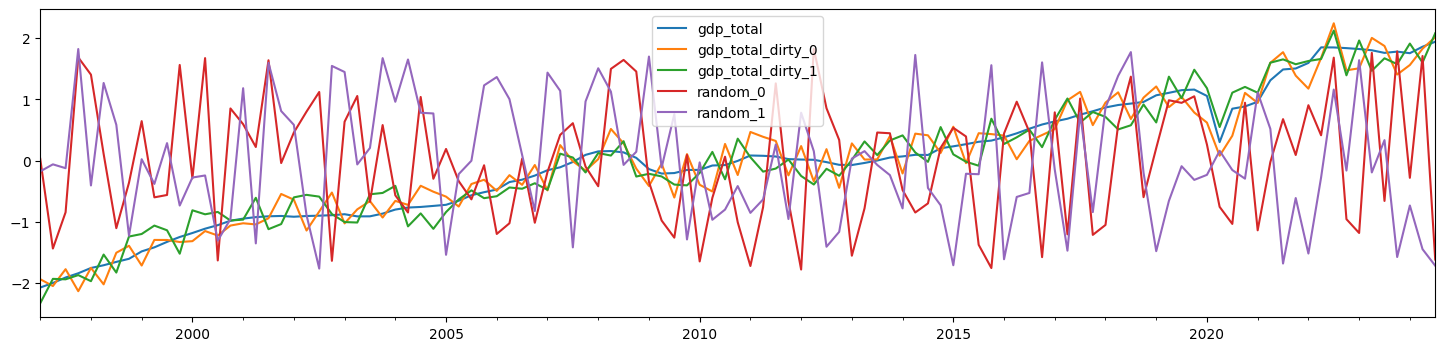

In [392]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()


#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [393]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [394]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:100,:]
    kw_test1['Qts'] = [1,2,3,4] * int(len(kw_test1)/4)
    kw_test1['Semi'] = [1,2] * int(len(kw_test1)/2)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

(111, 22)


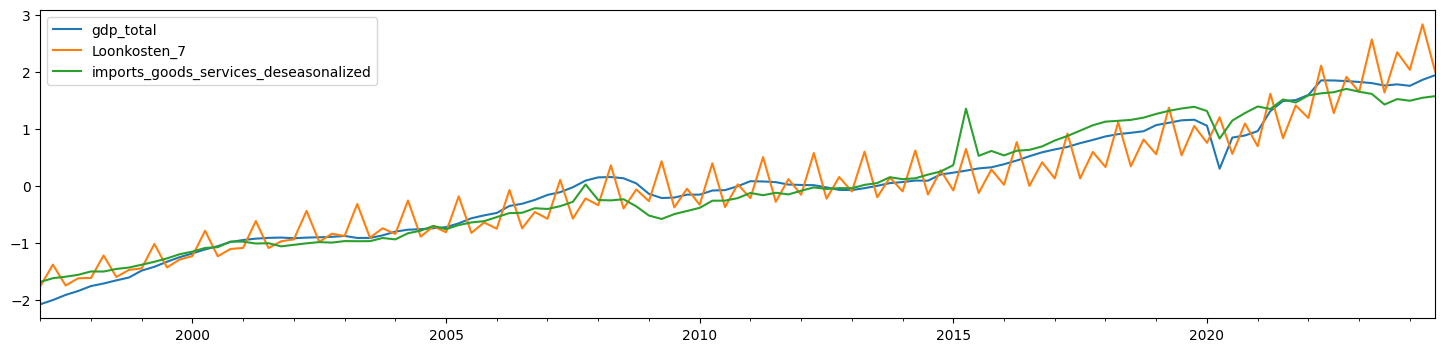

In [395]:
scaled_features_df[['gdp_total', 'Loonkosten_7', 'imports_goods_services_deseasonalized']].plot()

print(df1.shape)

In [396]:
def Kruskal_Wallis_Qt(data, STORE_FOR_TESTS): # Quarterly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Qts'].unique():
            res.append(data[data['Qts'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Qt_Seasonality'] = 'No_Qt_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Qt_Seasonality'] = 'Qt_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Qt(kw1, STORE_FOR_TESTS)

In [397]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Semi yearly
    
    for col in data.columns:
        # no need to test
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [398]:
scaled_features_df.dropna(inplace=True)

In [399]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)


deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=4)
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=4)
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df


,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1,trend
1997-01-01,-2.074168,-1.683564,-2.702177,-1.895247,-1.605610,-1.317996,-2.941456,NaN,-1.650418,-1.742759,...,-2.060607,NaN,NaN,NaN,NaN,-1.938111,-2.331245,0.029071,-0.176890,-1.716516
1997-04-01,-1.999720,-1.617105,-2.618598,-1.877221,-1.418978,-1.176012,-2.508790,NaN,-1.608152,-1.712186,...,-1.732228,NaN,NaN,NaN,NaN,-2.049724,-1.932389,-1.436947,-0.061656,-1.685307
1997-07-01,-1.910316,-1.590957,-2.502005,-1.842372,-1.472805,-1.242429,-2.391853,0.487953,-1.559507,-1.681113,...,-1.598597,-2.020816,-1.770595,-2.117530,-1.714381,-1.774487,-1.939941,-0.844366,-0.124352,-1.654098
1997-10-01,-1.840923,-1.557493,-2.376936,-1.803516,-1.446532,-1.218709,-2.359371,0.757148,-1.535963,-1.633655,...,-1.449428,-1.951723,-1.665841,-2.055953,-1.677960,-2.133905,-1.870703,1.685096,1.822213,-1.622888
1998-01-01,-1.754819,-1.498876,-2.221379,-1.742763,-1.184606,-0.949650,-2.351575,0.700367,-1.537619,-1.585398,...,-1.707367,-1.890238,-1.584763,-1.998176,-1.654039,-1.752743,-1.970197,1.403477,-0.406458,-1.591679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,1.759238,1.426721,1.798554,1.672248,1.468455,1.441889,0.860292,-0.634844,1.487069,2.161856,...,1.418975,1.542183,1.640901,1.557474,1.683279,1.871625,1.670679,-0.659402,0.333863,1.591679
2023-10-01,1.779709,1.521812,1.965264,1.741947,1.309377,1.314137,0.560154,-0.843759,1.581924,2.274707,...,1.632371,1.574488,1.663849,1.643973,1.703646,1.405162,1.575664,1.782835,-1.575947,1.622888
2024-01-01,1.754225,1.493070,2.040811,1.745953,1.370092,1.406308,0.354865,-0.964587,1.521568,2.329872,...,1.465591,1.608013,1.698495,1.739453,1.729100,1.560872,1.911469,-0.281799,-0.734040,1.654098
2024-04-01,1.859672,1.545088,1.925557,1.832610,1.429046,1.409528,0.812218,NaN,1.600964,2.382595,...,1.269807,NaN,NaN,NaN,NaN,1.827169,1.601446,1.708243,-1.447563,1.685307


[ 1  2  3  6  7  8 10 11 13 14 16 17]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'Spain_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


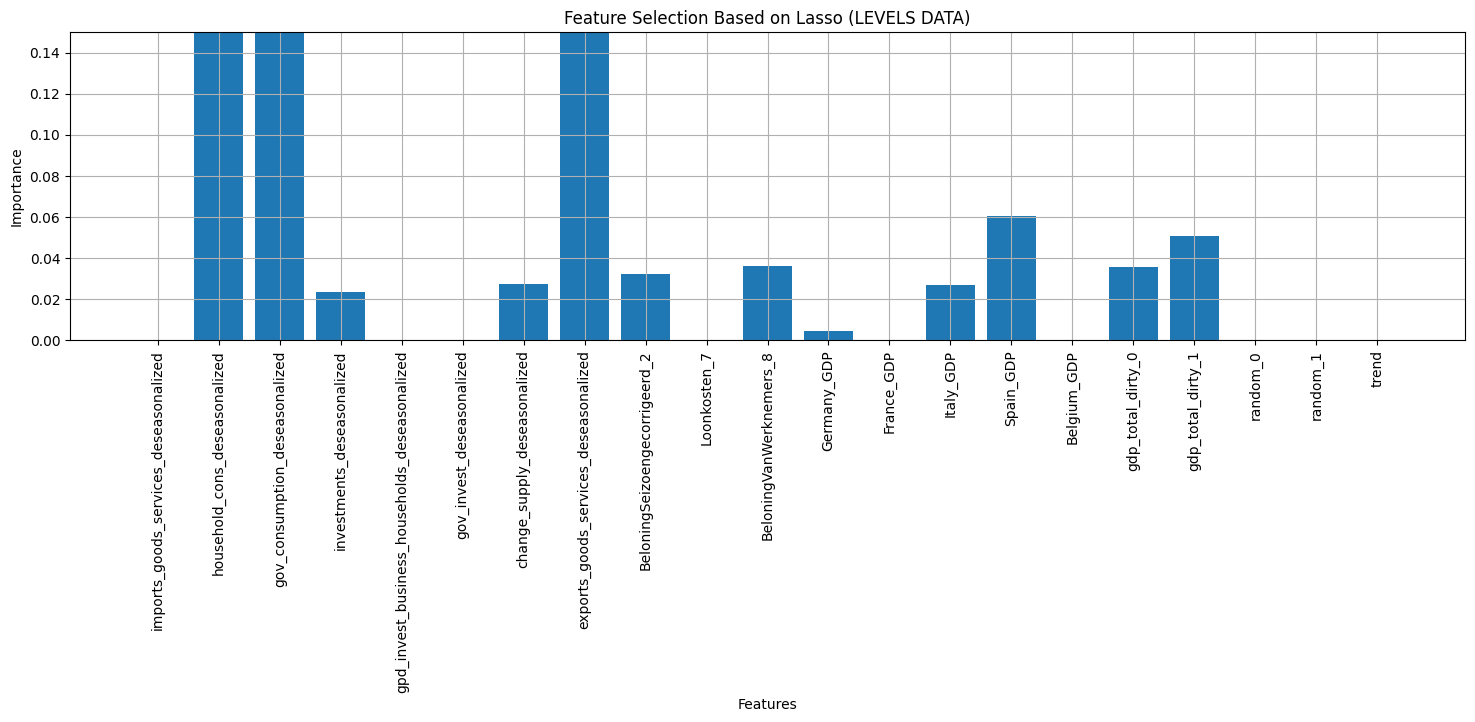

(111, 22)


In [400]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'gov_invest_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'Germany_GDP', 'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'trend']


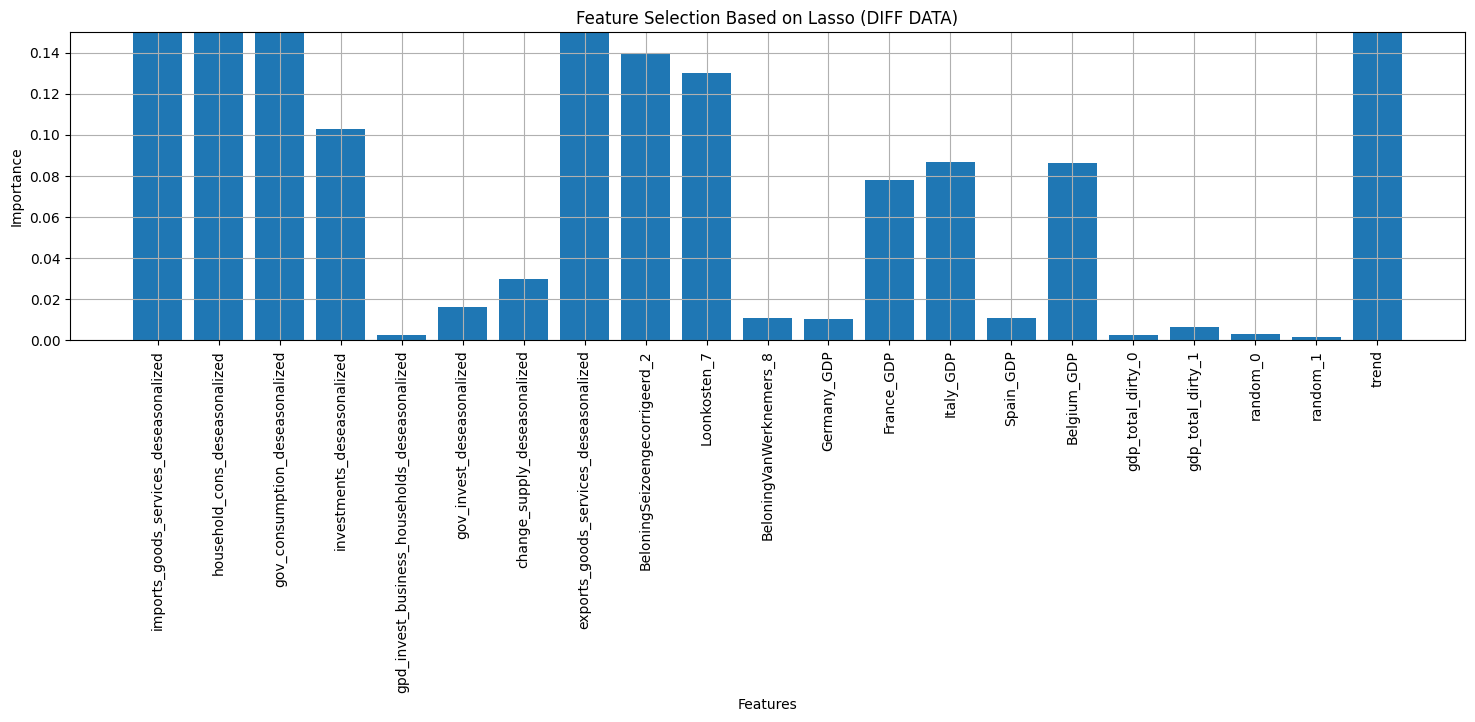

['imports_goods_services_deseasonalized',
 'household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'investments_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'gov_invest_deseasonalized',
 'change_supply_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningSeizoengecorrigeerd_2',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'France_GDP',
 'Italy_GDP',
 'Spain_GDP',
 'Belgium_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'trend']

In [401]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [402]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)


(111, 27)


[ 0  1  2  3  6  8 10 11 14 15 17 18 19 20 21 22 23 24 25]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'household_cons_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Loonkosten_7_lag_1', 'BeloningVanWerknemers_8_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'Spain_GDP_lag_1', 'Belgium_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1', 'trend_lag_1']


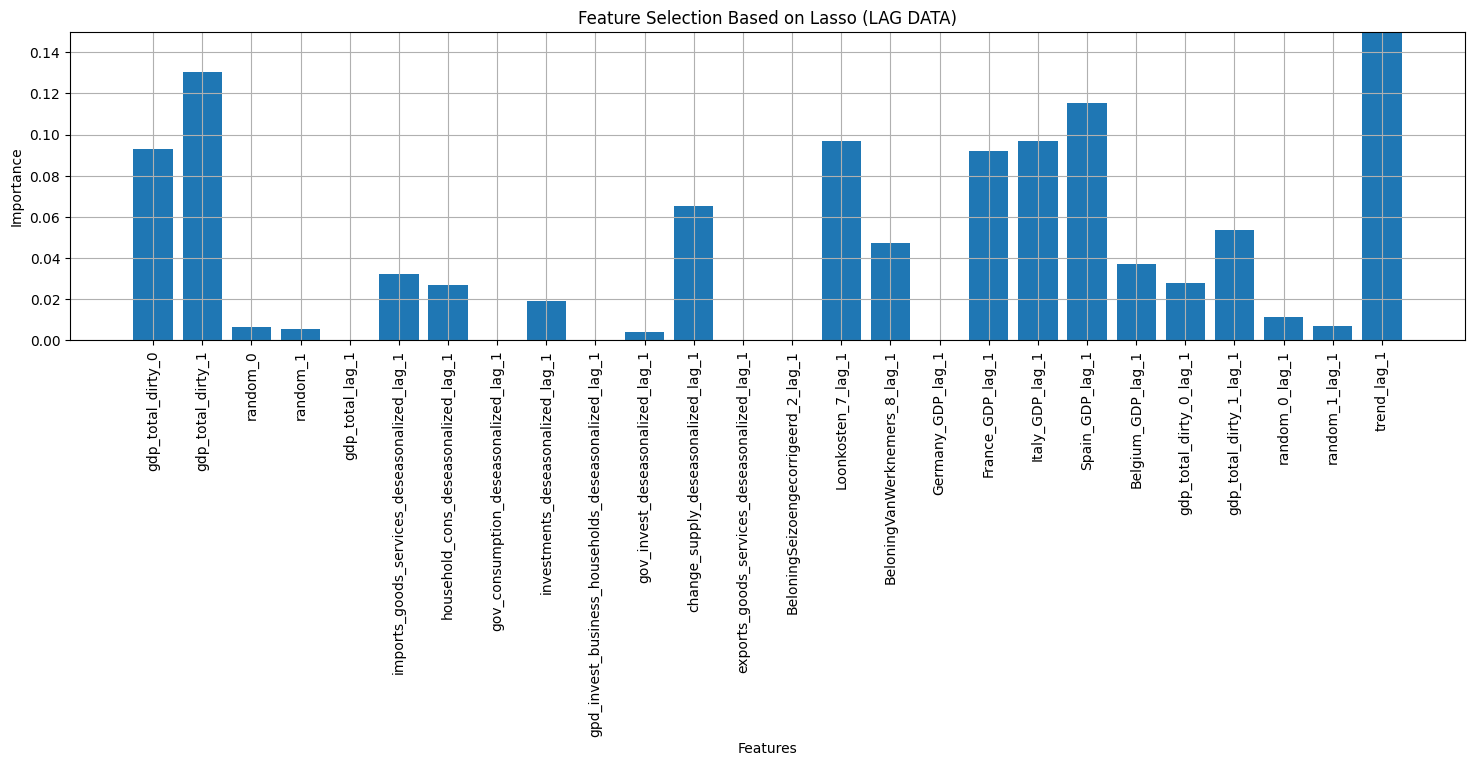

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'household_cons_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'Loonkosten_7_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'Spain_GDP_lag_1',
 'Belgium_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_0_lag_1',
 'random_1_lag_1',
 'trend_lag_1']

In [403]:
lassoreg(df_lag, alpha=0.001, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  2  3  4  5  6  7 10 11 13 16 17 18 19]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'gov_invest_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


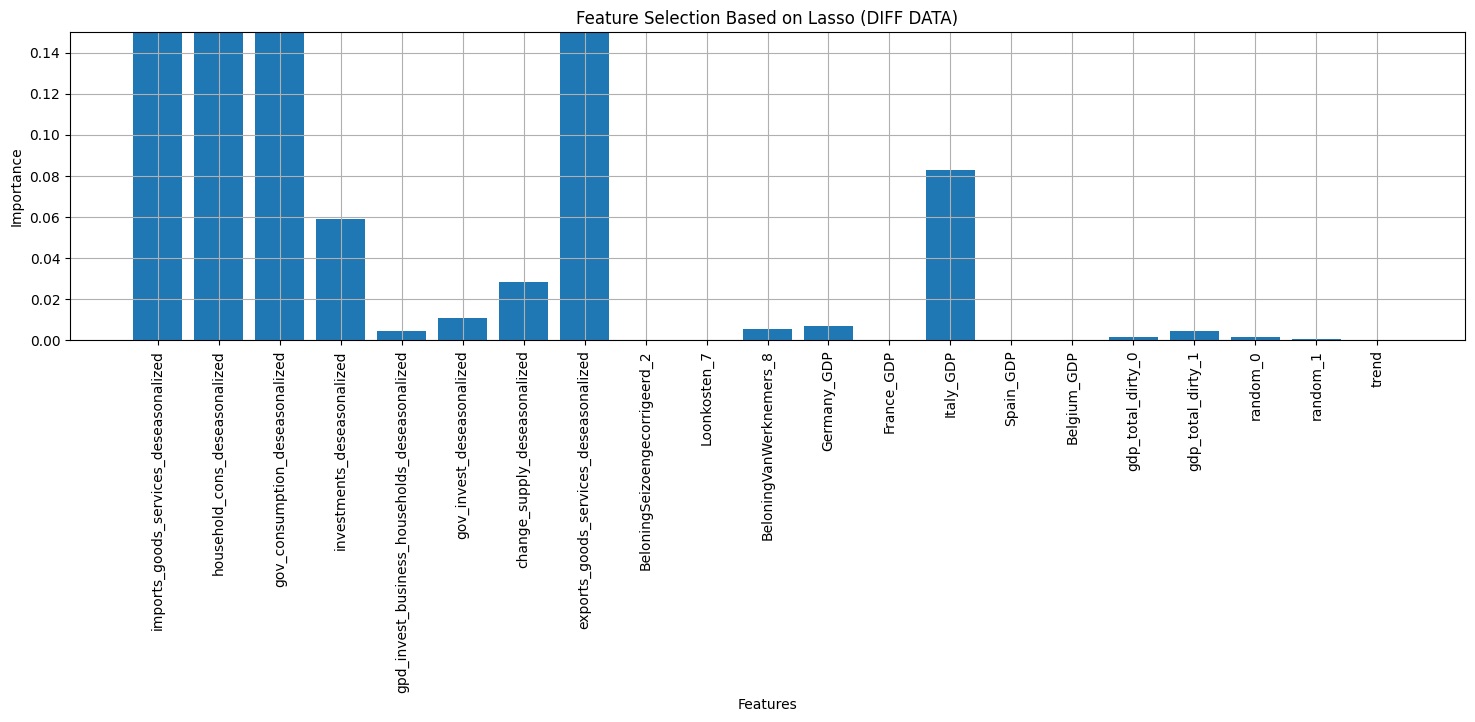

In [404]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

[ 0  1  2  4  6  9 10 16 17 18 21 22 23 24]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'gdp_total_lag_1', 'household_cons_deseasonalized_lag_1', 'gpd_invest_business_households_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


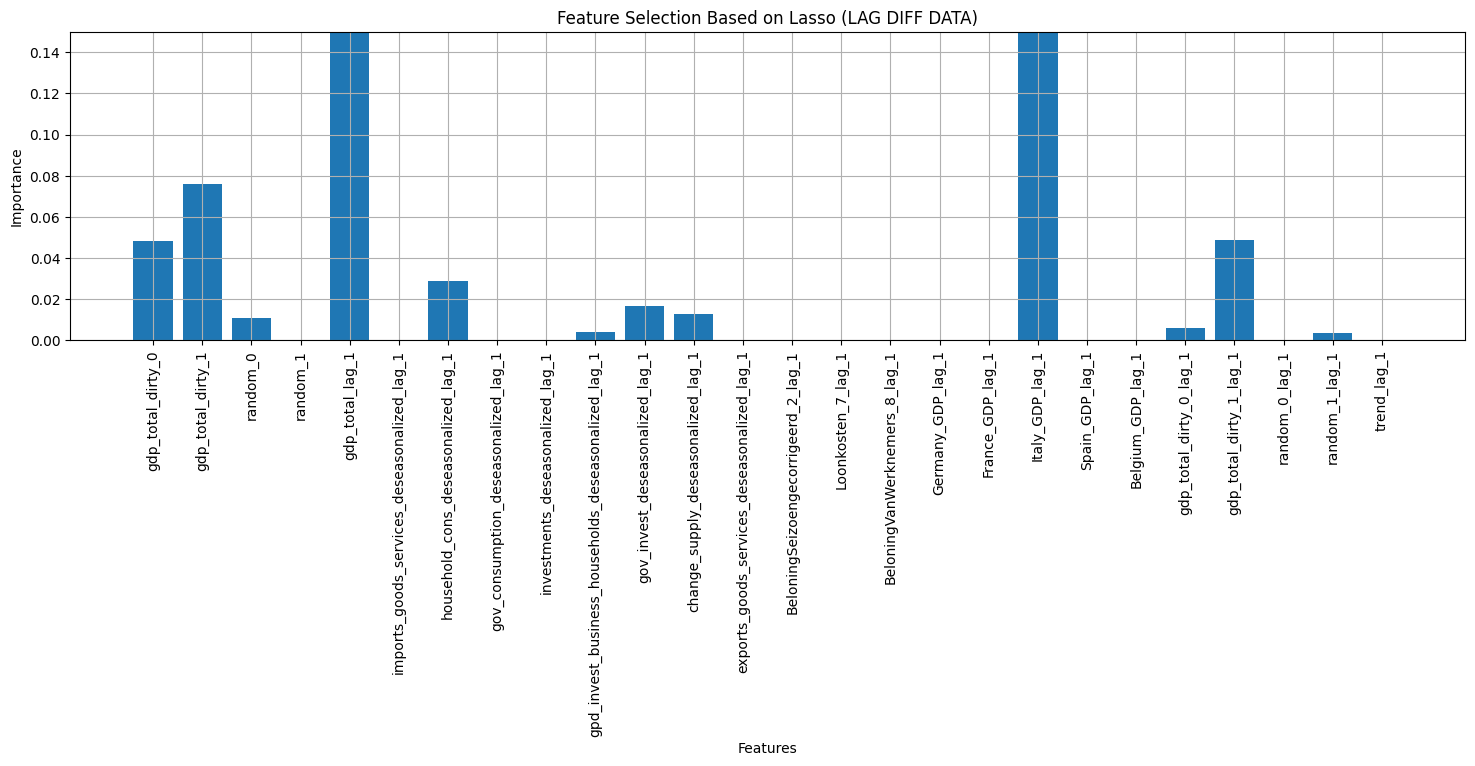

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'gdp_total_lag_1',
 'household_cons_deseasonalized_lag_1',
 'gpd_invest_business_households_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_0_lag_1',
 'random_1_lag_1']

In [405]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [406]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [407]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [408]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)


(22, 3)


### If not stationary, difference, then test for stationarity again

In [409]:

def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]

print(scaled_features_df_diff.shape)


(111, 22)


In [410]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
change_supply_deseasonalized,No_Qt_Seasonality,Semi_Seasonality,NotStationary,Stationary,True
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,NotStationary,True


<Axes: >

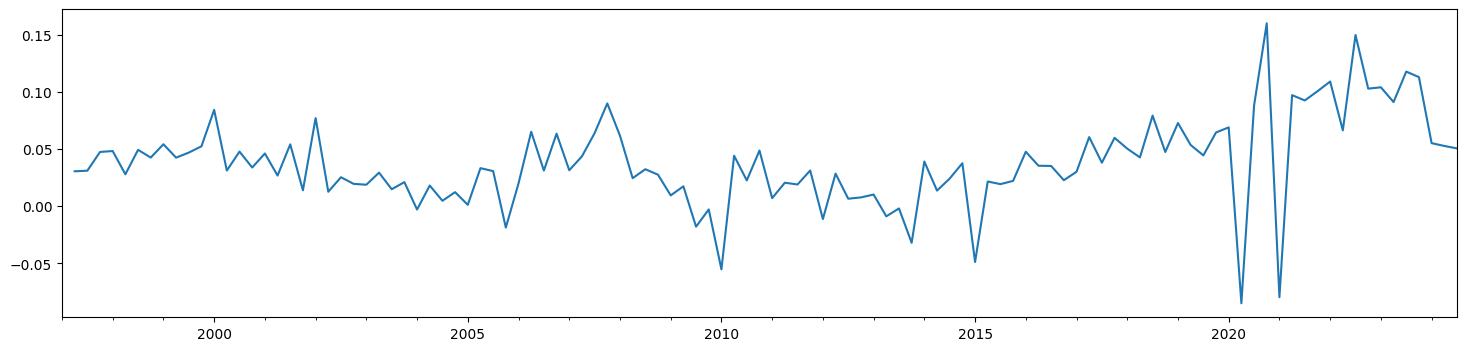

In [411]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2'].plot()

[ 1  2  4  6  7 10 11 13 18]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'random_0']


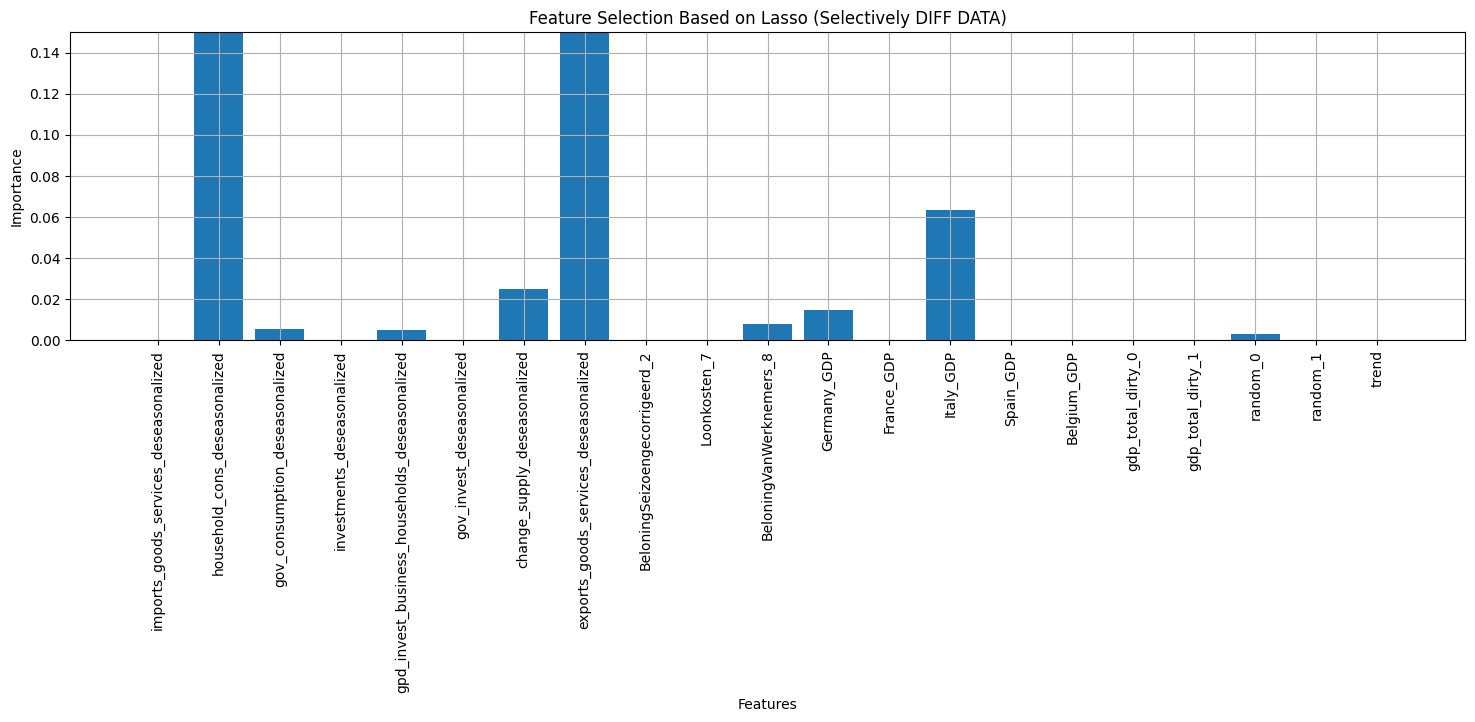

['household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'change_supply_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'Italy_GDP',
 'random_0']

In [412]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(111, 22)


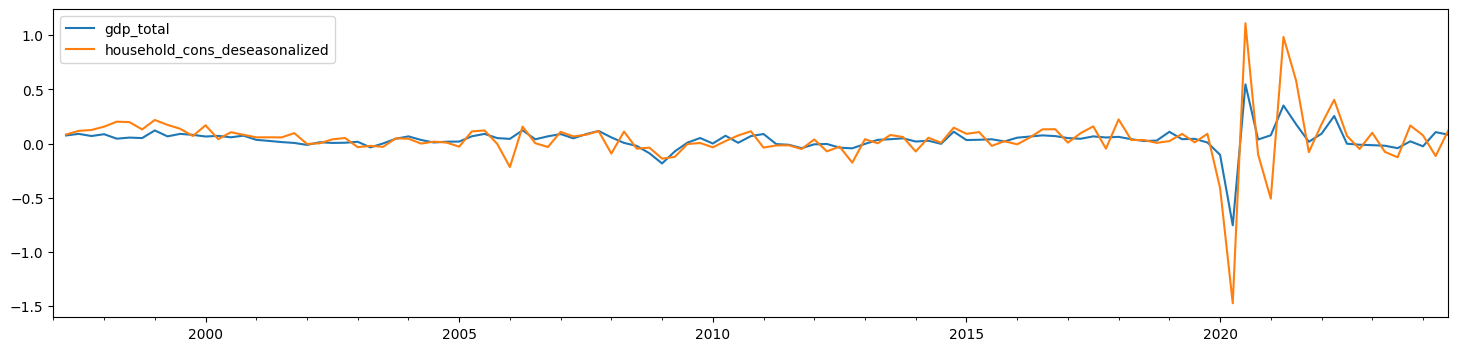

In [413]:
scaled_features_df_diff[['gdp_total', 'household_cons_deseasonalized']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [414]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(111, 44)


In [415]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]


In [416]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(111, 19)


[ 0  2  6 12 13 14]
['gdp_total_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1']


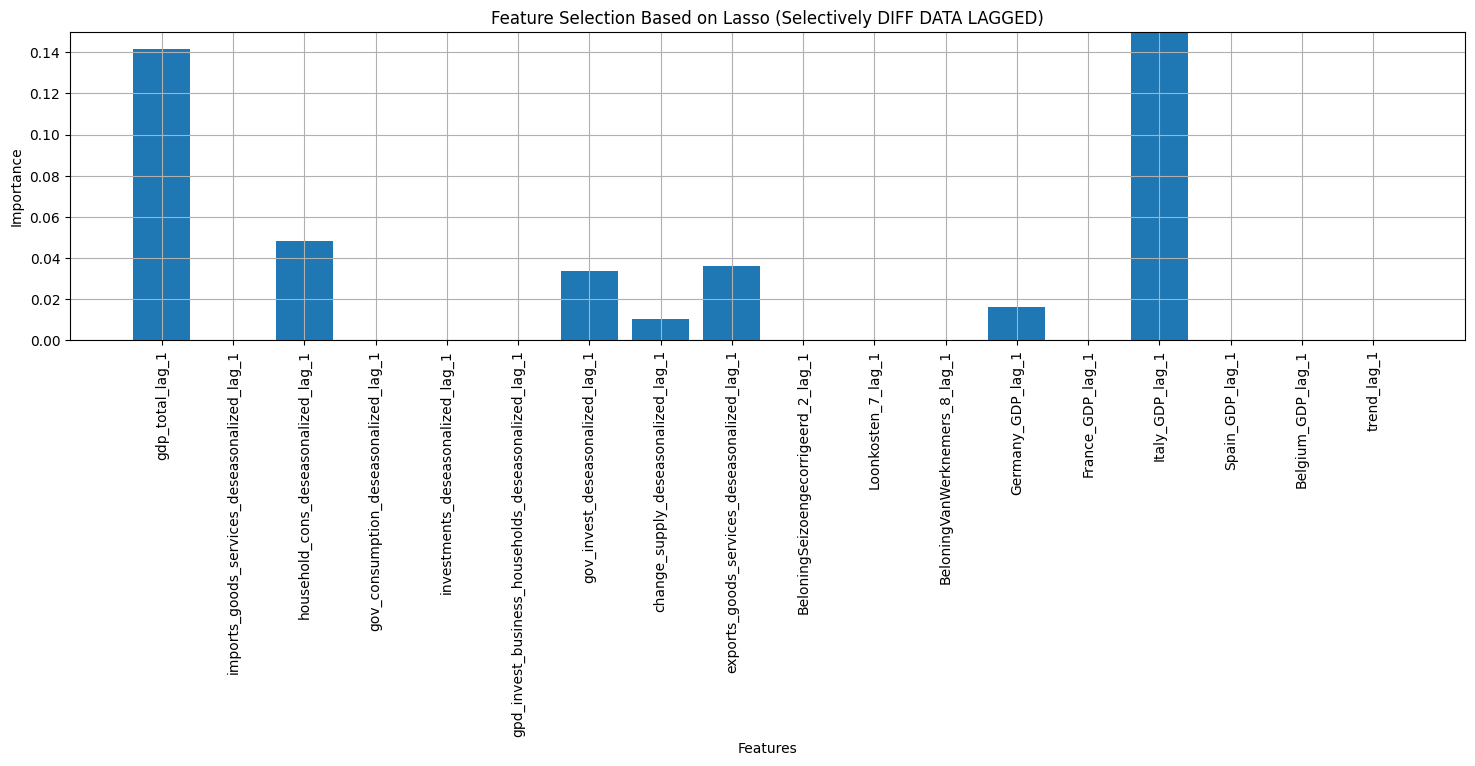

In [417]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

,gdp_total,gdp_total_lag_1,household_cons_deseasonalized_lag_1,gov_invest_deseasonalized_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1
1997-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-04-01,0.074448,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-01,0.089405,0.074448,0.083578,0.432666,0.328380,NaN,NaN
1997-10-01,0.069393,0.089405,0.116593,0.116937,0.133631,NaN,NaN
1998-01-01,0.086104,0.069393,0.125070,0.032482,0.149169,0.069093,0.104754
...,...,...,...,...,...,...,...
2023-07-01,-0.042572,-0.020137,-0.077035,-0.232574,-0.272440,0.032813,0.001044
2023-10-01,0.020471,-0.042572,-0.126854,0.366402,0.179209,0.043693,0.005177
2024-01-01,-0.025484,0.020471,0.166710,-0.300138,0.213395,0.032305,0.022949
2024-04-01,0.105447,-0.025484,0.075548,-0.205289,-0.166780,0.033525,0.034646


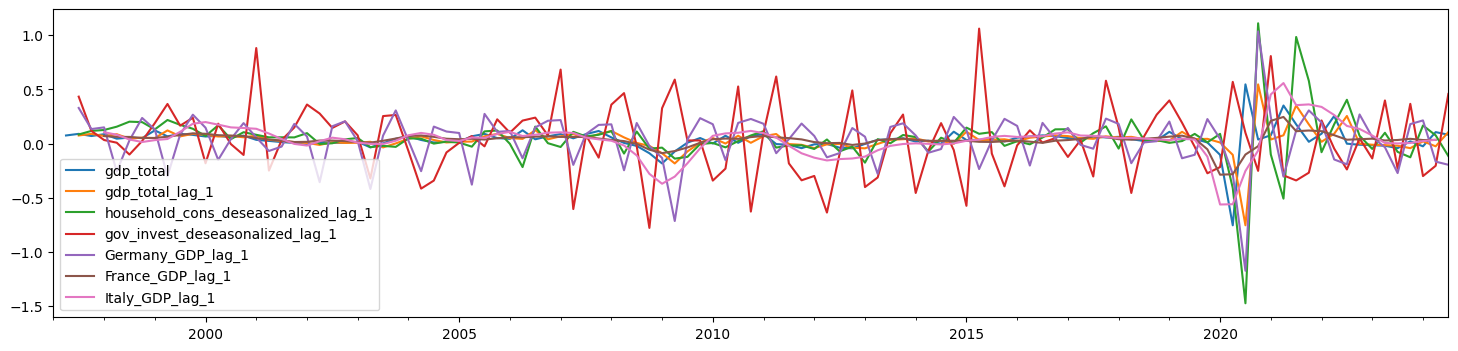

In [418]:
chooseThese = ['gdp_total'] + lasout
scaled_features_df_diff_lag[chooseThese].plot()
scaled_features_df_diff_lag[chooseThese]

<Axes: >

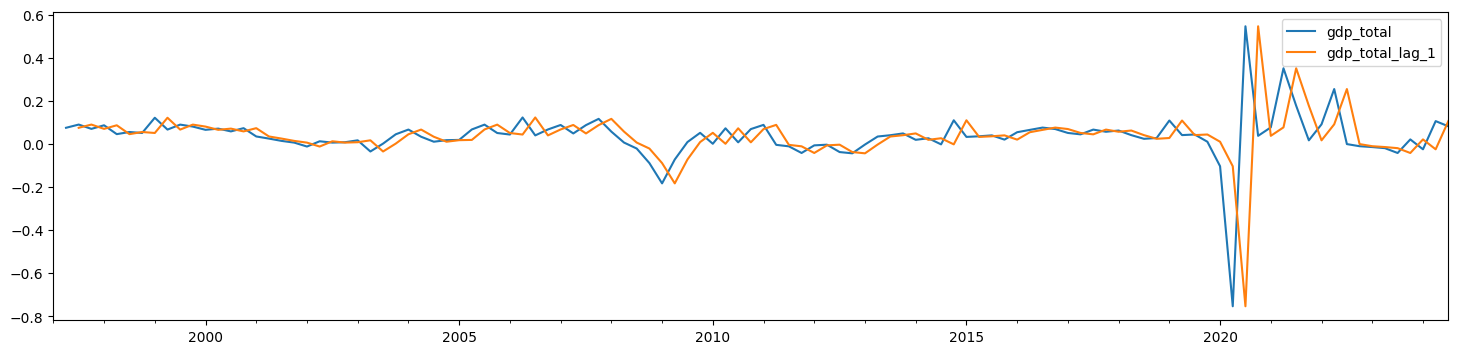

In [419]:
scaled_features_df_diff_lag[['gdp_total','gdp_total_lag_1']].plot()

In [420]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2023-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     14.50
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.20e-11
Time:                        09:48:32   Log-Likelihood:                 110.50
No. Observations:                 101   AIC:                            -207.0
Df Residuals:                      94   BIC:                            -188.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

<Axes: >

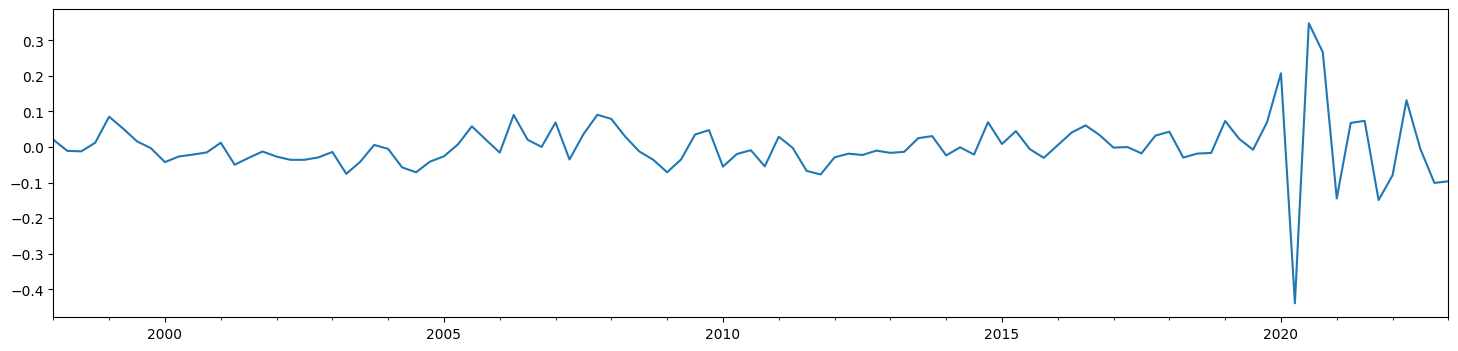

In [421]:
results.resid.plot()

<Axes: >

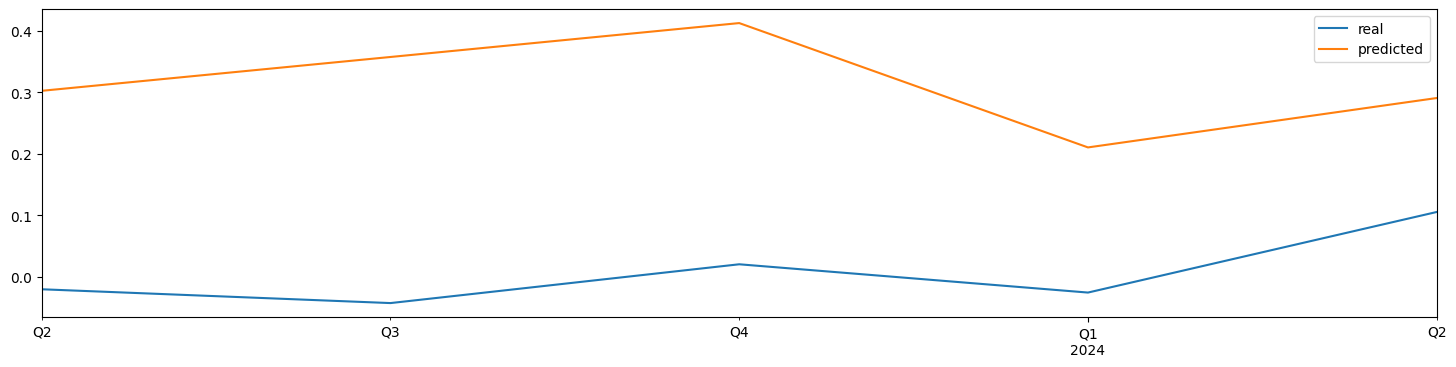

In [422]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


Homoskedasticity (Breusch-Pagan)


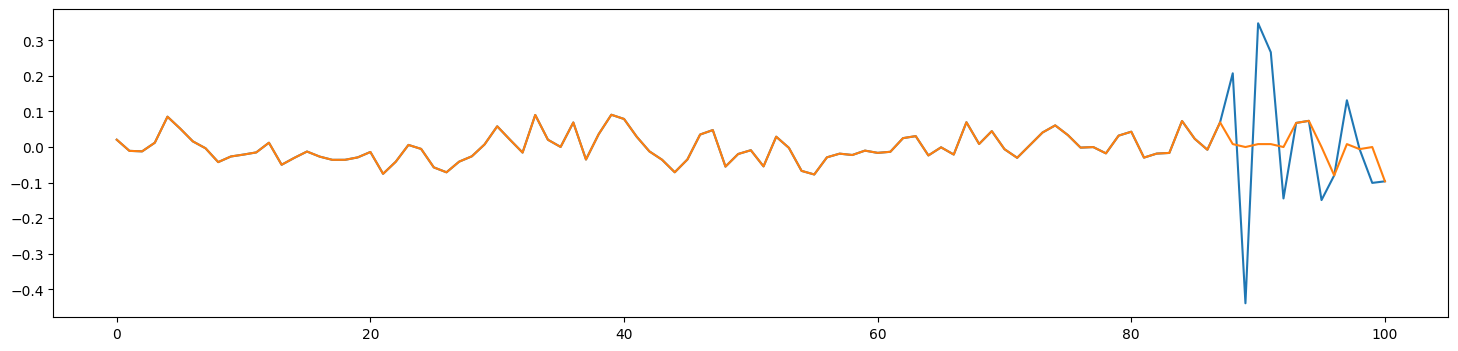

In [423]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Homoskedasticity
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

In [424]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Homoskedasticity (White)


### Colinearity

In [425]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

1.250128371654297
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


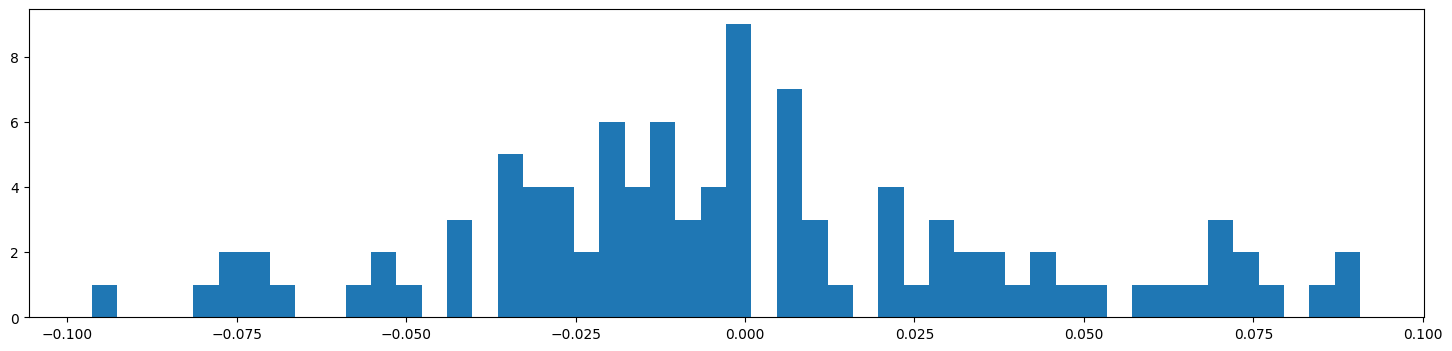

In [426]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [427]:
y_true

1998-01-01    0.086104
1998-04-01    0.044911
1998-07-01    0.054896
1998-10-01    0.050342
1999-01-01    0.121030
                ...   
2022-01-01    0.090533
2022-04-01    0.254302
2022-07-01   -0.001253
2022-10-01   -0.011071
2023-01-01   -0.014998
Name: gdp_total, Length: 101, dtype: float64

In [428]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
1995-01-01,NaN,NaN,NaN
1995-04-01,NaN,NaN,NaN
1995-07-01,NaN,NaN,NaN
1995-10-01,NaN,NaN,NaN
1996-01-01,135716.0,NaN,NaN
...,...,...,...
2023-07-01,233430.0,1.759238,-0.042572
2023-10-01,233920.0,1.779709,0.020471
2024-01-01,233310.0,1.754225,-0.025484
2024-04-01,235834.0,1.859672,0.105447


In [429]:
def test_reverse_transform(start_date_analysis, my_data_to_untransform):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = my_data_to_untransform
    date_start_difference = pd.to_datetime(start_date_analysis) 

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))

    return test1

tes1 = test_reverse_transform(start_date_analysis, y_true)


In [430]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred

GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff,predicts_before_transformations
1995-01-01,NaN,NaN,NaN,NaN
1995-04-01,NaN,NaN,NaN,NaN
1995-07-01,NaN,NaN,NaN,NaN
1995-10-01,NaN,NaN,NaN,NaN
1996-01-01,135716.0,NaN,NaN,NaN
...,...,...,...,...
2023-07-01,233430.0,1.759238,-0.042572,0.357313
2023-10-01,233920.0,1.779709,0.020471,0.412403
2024-01-01,233310.0,1.754225,-0.025484,0.210360
2024-04-01,235834.0,1.859672,0.105447,0.290620


In [443]:
predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].dropna().values)
GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()

ValueError: Length of values (111) does not match length of index (119)

In [ ]:

predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:-1])
GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()

In [365]:
lasout1 = ['gdp_total'] + lasout

reg1 = scaled_features_df_diff_lag[lasout1]
#reg1 = scaled_features_df_diff_lag[['gdp_total', 'investments_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'Italy_GDP_lag_1']]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

########################
test_train_split = 109
########################

X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     14.66
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           6.51e-12
Time:                        09:40:33   Log-Likelihood:                 116.75
No. Observations:                 106   AIC:                            -219.5
Df Residuals:                      99   BIC:                            -200.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1,trend_lag_1
1997-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-04-01,0.074448,0.066459,0.083578,0.018026,0.186632,0.141984,0.432666,NaN,0.042266,0.030573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.222133,-1.007758,NaN
1997-07-01,0.089405,0.026147,0.116593,0.034850,-0.053827,-0.066418,0.116937,NaN,0.048645,0.031073,...,0.328380,NaN,NaN,NaN,NaN,0.627520,-0.312079,0.054747,0.177101,0.031209
1997-10-01,0.069393,0.033464,0.125070,0.038855,0.026273,0.023721,0.032482,0.269195,0.023543,0.047458,...,0.133631,NaN,NaN,NaN,NaN,-0.553609,0.180001,-0.187490,0.006826,0.031209
1998-01-01,0.086104,0.058617,0.155557,0.060753,0.261926,0.269059,0.007796,-0.056781,-0.001656,0.048258,...,0.149169,0.069093,0.104754,0.061577,0.036422,0.176740,0.421782,0.250294,1.053102,0.031209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.042572,-0.185737,-0.126854,0.141135,-0.137611,-0.196033,0.366402,-0.520539,-0.124680,0.117696,...,-0.272440,0.032813,0.001044,0.053322,0.009820,-0.386166,0.151209,-1.097849,-1.053205,0.031209
2023-10-01,0.020471,0.095091,0.166710,0.069700,-0.159078,-0.127752,-0.300138,-0.208915,0.094856,0.112851,...,0.179209,0.043693,0.005177,0.067906,0.012942,-0.390733,0.068872,1.147762,-1.524256,0.031209
2024-01-01,-0.025484,-0.028743,0.075548,0.004006,0.060716,0.092171,-0.205289,-0.120828,-0.060356,0.055166,...,0.213395,0.032305,0.022949,0.086499,0.020366,0.071237,0.236348,-0.075272,0.234696,0.031209
2024-04-01,0.105447,0.052018,-0.115255,0.086657,0.058953,0.003219,0.457353,NaN,0.079395,0.052723,...,-0.166780,0.033525,0.034646,0.095480,0.025454,0.506894,0.104807,1.727439,-1.367890,0.031209


<Axes: >

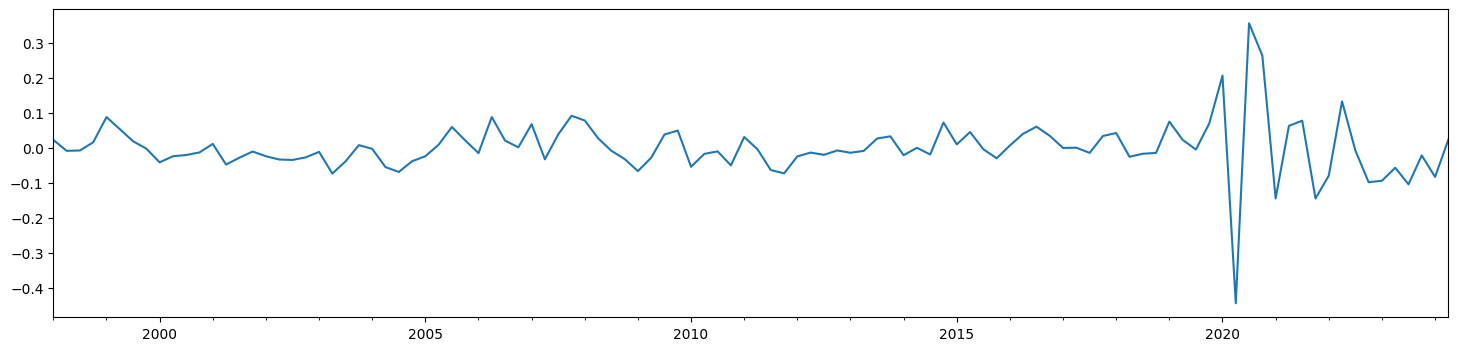

In [366]:
results.resid.plot()

In [367]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1

In [368]:
reg1.iloc[test_train_split:, 0]

Series([], Name: gdp_total, dtype: float64)

Empty DataFrame
Columns: [real, predicted]
Index: []


<Axes: >

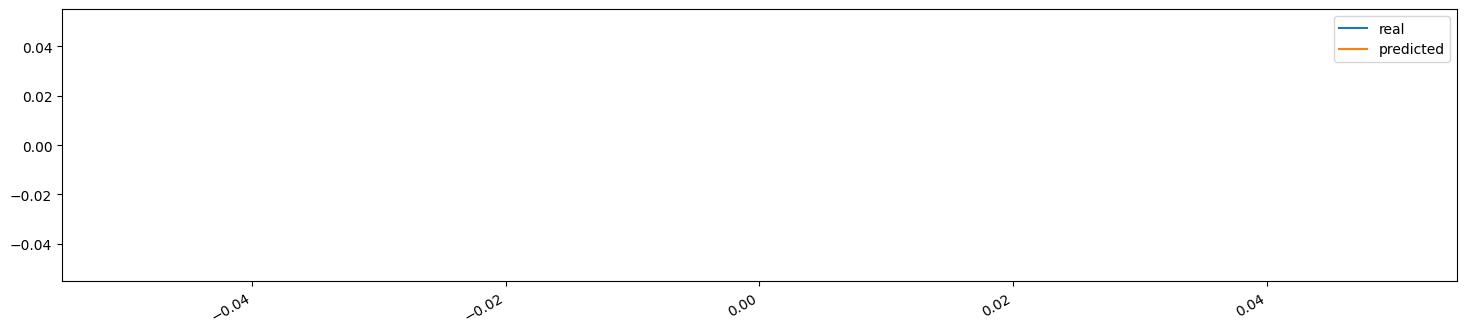

In [369]:

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.iloc[test_train_split:, 0], 'predicted': ynewpred})
print(df_pred)
df_pred.plot()

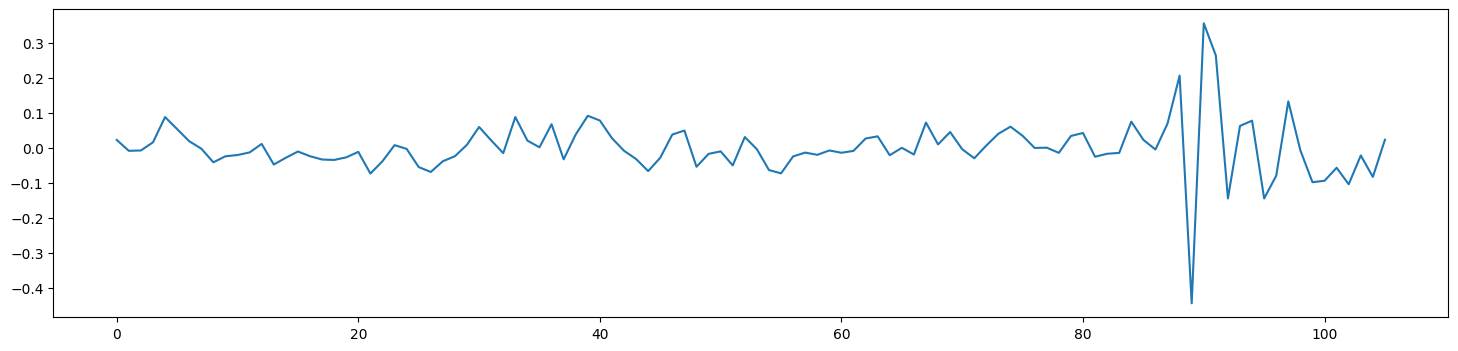

In [370]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

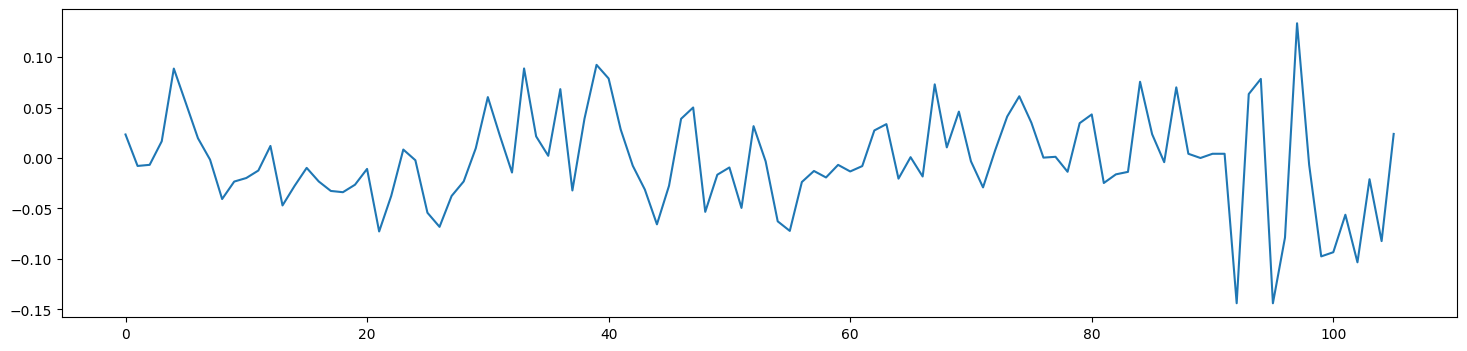

In [371]:
results.resid[results.resid < -0.4] = np.mean(results.resid)
results.resid[results.resid > 0.2] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Homoskedasticty

In [372]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Heteroskedasticity (Breusch-Pagan)


In [373]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Collinearity

In [374]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

1.5392509383260113
Positive autocorrelation is significant


### Normality

Residuals are normally distributed


(array([ 5., 16., 56., 23.,  6.]),
 array([-0.14392981, -0.08845122, -0.03297263,  0.02250597,  0.07798456,
         0.13346315]),
 <BarContainer object of 5 artists>)

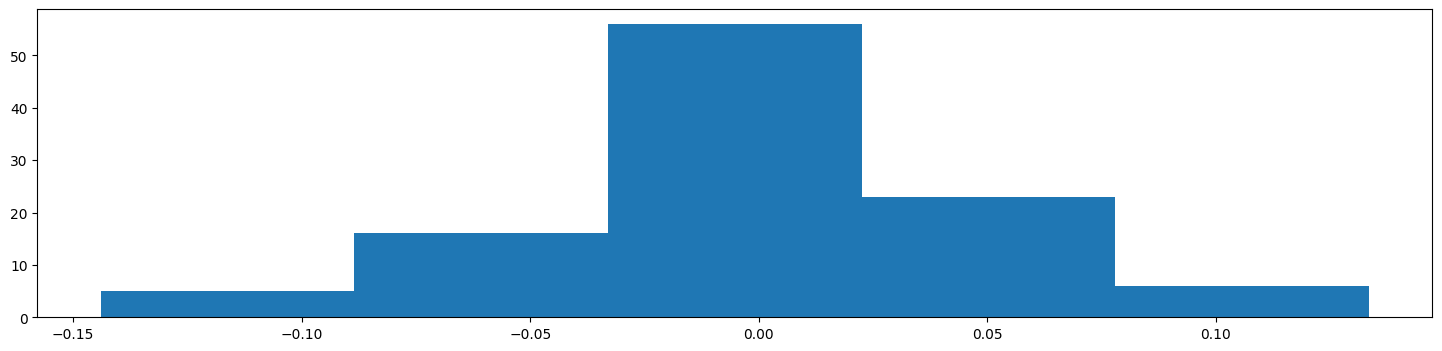

In [375]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=5)

In [376]:
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
change_supply_deseasonalized,No_Qt_Seasonality,Semi_Seasonality,NotStationary,Stationary,True
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,NotStationary,True
